In [28]:
#импорт библиотек
from warnings import filterwarnings
filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA


1. 
    * Прочитайте исходный файл с данными. 
    * Визуализируйте исходный временной ряд
    * Сделайте первичные выводы о присутствии компонент тренда и сезонности в ряде.
    * Отложите последние три года из датасета как тестовую выборку для оценки результатов предсказания.

In [3]:
#Прочитаем данные и приведем в удобный вид (Год в формате номера года, названия фич к одному регистру)
data = pd.read_csv('ghana_gdp.csv', parse_dates=['year'])
data = data.rename({'GDP (current US$)':'GPD'}, axis=1)
data['year'] = pd.to_datetime(data['year'])
#data['year'] = data['year'].dt.year
data = pd.DataFrame(data['GPD'].values, index=data['year']).rename({0:'gpd'},axis=1)
data.head(3)

,gpd
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09


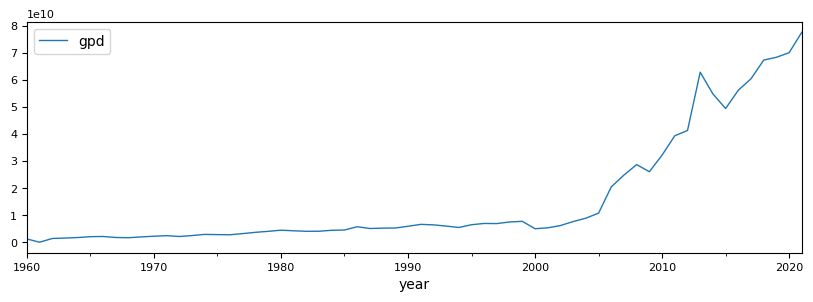

In [4]:
# Визуализируем ряд как он есть
%matplotlib inline

plt.rcParams["figure.figsize"] = 10, 3
plt.rcParams["font.size"] = 10
plt.rcParams["xtick.labelsize"] = 8
plt.rcParams["ytick.labelsize"] = 8
plt.rcParams["lines.linewidth"] = 1

data.plot()
plt.show()

- - -
    Выводы:
    - Сезонности не видно (да и оно логично, ВВП стран +/- расчет в длинной динамике по годам)
    - Тренд есть, более того график можно разделить на 2е явно выраженные части по тренду, в каждой их которых трнед примерно линейный. Виден "слом тренда" на более высокие темпы роста с середины 2000х
    - Стационарности вообще, я бы не предполагал т.к. тренд явно выражен, а значит матожидание в период 2010+, например, явно отличается от матожидания до 2000


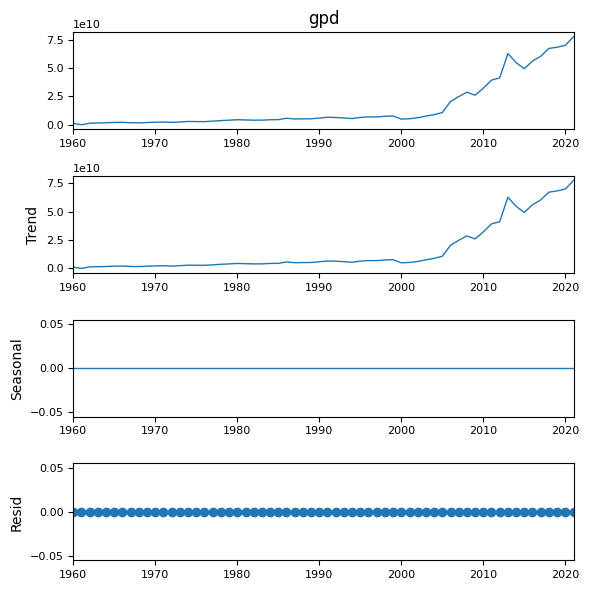

In [5]:
# Посмотрим, как на тренд и сезонную составляющую через метод сезонной декомпозиции
plt.rcParams["figure.figsize"] = 6, 6

result = seasonal_decompose(data.gpd)
result.plot()
plt.show()

- - -
    Видим, что выделяется один тренд. Рискну предположить, что модели прогнозирования сработают хорошо, т.к. у нас нет ни шумов, ни сезонности, а тренд "на глаз" состоит из двух линейных кусков

In [6]:
#Разделим выборку на тестовую и тренировочную. В тренировочную положим последние 3 года
train_df = data.iloc[:-3]
test_df = data.iloc[-3:]

2. * Постройте модель скользящего среднего, проанализируйте результат. Для построения MA используйте метод rolling(), который принимает в качестве параметра размер окна. Используйте среднее как функцию для сглаживания. Ширину окна подберите самостоятельно.
    * Визуализируйте исходный временной ряд и построенный с помощью скользящего среднего прогноз, сравните графики между собой и сделайте выводы.

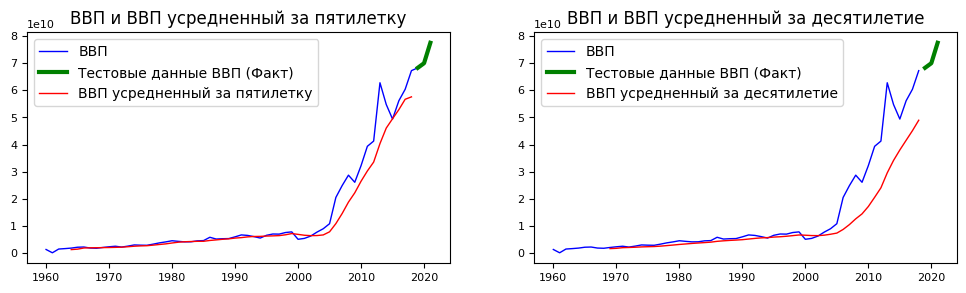

In [7]:
plt.rcParams["figure.figsize"] = 12, 3

fig, ax = plt.subplots(1, 2)

# Окно в Пятилетку
ax[0].plot(data['gpd'], color="blue", label="ВВП")
ax[0].plot(test_df['gpd'], color="green", label="Тестовые данные ВВП (Факт)", lw=3)

ax[0].plot(
    train_df['gpd'].rolling(window=5).mean(),
    color="red",
    label="ВВП усредненный за пятилетку",
)

ax[0].set_title("ВВП и ВВП усредненный за пятилетку")
ax[0].legend()

# Окно в Десятилетие
ax[1].plot(train_df['gpd'], color="blue", label="ВВП")
ax[1].plot(test_df['gpd'], color="green", label="Тестовые данные ВВП (Факт)", lw=3)

ax[1].plot(
    train_df['gpd'].rolling(window=10).mean(),
    color="red",
    label="ВВП усредненный за десятилетие",
)

ax[1].set_title("ВВП и ВВП усредненный за десятилетие")
ax[1].legend()

plt.show()

- - -
    Выводы:
    - Чем больше период окна, тем больше MA отстает от изменения тренда
    - В целом MA конечно плохо прогнозирует такую картинку, когда тренд резкий, оценка занижена или завышена. Тут вопрос и в том как "продалять" правильно красную линию скользящего среднего до прогноза и не надо ли ее "адаптировать" к более свежим данным. 
    - Тут кстати должна лучше сработать из простых модель экспоненциального сглаживания, т.к. "свежие данные" сильнее влияют. Давайте проверим эту гипотезу ниже (понятно, что тут есть явное когнитивное искажение, т.к. факт уже нарисован на картинке и я подбираю модель, которая луше предскажет видимый глазом результат, но все равно интересно):

c:\Users\killr\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


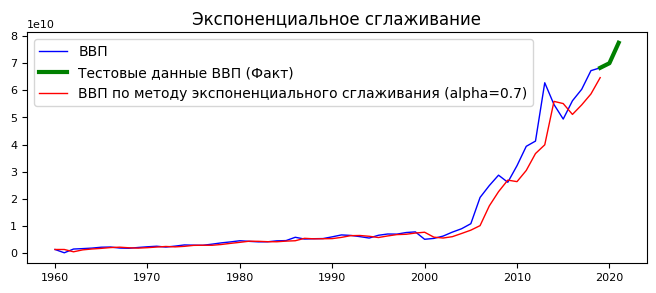

In [8]:
# Попробуем эеспоненциальное сглаживание. Тут логично его применить и интересно,ч то получится
from statsmodels.tsa.api import SimpleExpSmoothing

ses = SimpleExpSmoothing(train_df)
model = ses.fit(smoothing_level = 0.7, optimized = False)
#print(model.fittedvalues)

plt.rcParams["figure.figsize"] = 8, 3

fig, ax = plt.subplots(1, 1)

# Окно в Пятилетку
ax.plot(data['gpd'], color="blue", label="ВВП")
ax.plot(test_df['gpd'], color="green", label="Тестовые данные ВВП (Факт)", lw=3)

ses_graph = pd.concat([model.fittedvalues, model.forecast(1)], axis=0)
ax.plot(
    ses_graph,
    color="red",
    label="ВВП по методу экспоненциального сглаживания (alpha=0.7)",
)

ax.set_title("Экспоненциальное сглаживание")
ax.legend()


- - -
    Вывод:
    - Подгоняя модель под ответ, получили более точный прогноз (кто бы сомневался :) )
    - И все равно методы усреднения "подстраховываются", ну явно линейная часть тренда "красной линии" ниже, чем нужно

3.  * С помощью теста Дики-Фуллера оцените стационарность временного ряда и примите решение о выборе модели ARMA/ARIMA.
    * Параметры p и q выберите по коррелограммам ACF и PACF.
    * Постройте модель ARMA/ARIMA для прогнозирования поведения временного ряда.
    * Также постройте несколько моделей с параметрами, ближайшими к найденным p и q, и сравните коэффициент AIC (или подберите наилучшие параметры с помощью пакета pmdarima, как в скринкасте).

In [15]:
# Сделем тест на стационарность. Проверим заодно мою гипотезу о нестационарности исходных данных
# Напишем функцию, которая возвращает чилсо дифференцирований до стационарности
def get_static_depth(x):
    row = x.copy()
    for i in range(10):
        test1 = adfuller(row)
        if test1[0] <= test1[4]["5%"]:
            return i
        
        row = row.diff().dropna()
        
    print('Нестационарен при 9 дифференцированиях')
    return -1
    
get_static_depth(train_df)    

3

- - -
    - Получили самое глубокое дифференцирование из всех примеров, которые пока я видел. Я думал хватит 2х, если честно (хотя было ясно, что не хватит одного)
    - Мне очень интересно, как ряд меняется при дифференцированиях, поэтому сделаю визуализацию:


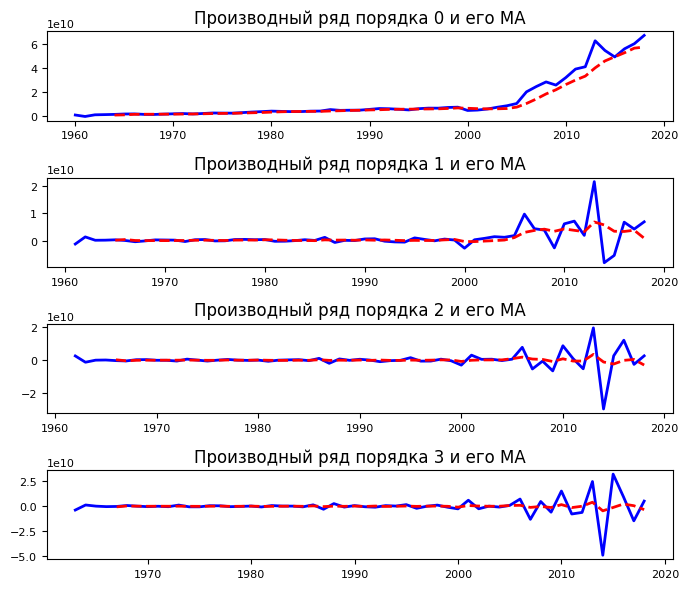

In [16]:
#Визуализация ряда и его последовательных "производных" до 3его порядка
diff_row = train_df.copy()
fig, ax = plt.subplots(4, 1)

plt.rcParams["figure.figsize"] = 7, 6
for i in range(4):
    ax[i].plot(diff_row['gpd'], color="blue", lw=2)
    ax[i].plot(diff_row['gpd'].rolling(window=5).mean(), color="red", linestyle='--', lw=2)
    diff_row = diff_row.diff().dropna()
    title = f'Производный ряд порядка {i} и его MA'
    ax[i].set_title(title)
plt.tight_layout()


- - -
    Выводы и наблюдение:
    - Есть новая гипотеза, что второй производный ряд был близок к стационарности
    - Скользящее среднее я вывед не только для красоты, но чтобы увидеть наглядно, что среднее значение ряда одинаково в итоговом ряде
    - Ну и будем использовать ARIMA т.к. она применяется для нестационарныз рядок
    - Порядок дифференцирования d для ARIMA уже определили и он = 3
    - Наглядно видно, что дисперсия увеличивается со временем. Это будем учитывать позже, сначала построим модели, которые не учитывают это.

    Далее подберем параметры p и q количества переменных авторегресии и скользящего среднего шумовой компоненты соответственно:


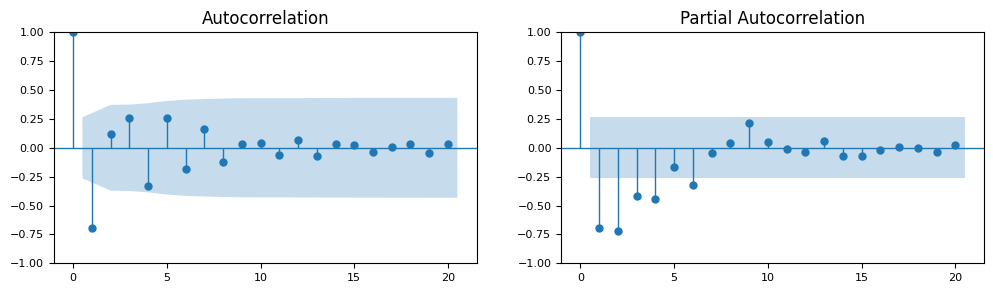

In [64]:
#Построим кореллограммы для 3его производного ряда, чтобы определиться с параметрами p и q
fig, ax = plt.subplots(1, 2)

plt.rcParams["figure.figsize"] = 12, 3
sgt.plot_acf(diff_row, ax=ax[0], lags=20)
sgt.plot_pacf(diff_row, ax=ax[1], lags=20, method="ywm")
plt.show()

- - -
    - Определяем p по графику частичной автокорреляции (правому). Я бы попробовал 4 и 6. Думаю, что 4 будет лучше.
    - Определяем q по графику автокорреляции (левому) и это 1 без вариантов
    
    Проверим сразу свои выводы с помошью инструментария pmdarima:

In [59]:
smodel = pm.auto_arima(
    train_df,
    start_p=1,
    d=3,
    start_q=1,
    max_p=6,
    max_q=1,
    test="adf",
    error_action="ignore",
    trace=True,
)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,3,1)(0,0,0)[0]             : AIC=2670.910, Time=0.06 sec
 ARIMA(0,3,0)(0,0,0)[0]             : AIC=2734.956, Time=0.02 sec
 ARIMA(1,3,0)(0,0,0)[0]             : AIC=2707.192, Time=0.02 sec
 ARIMA(0,3,1)(0,0,0)[0]             : AIC=2682.371, Time=0.03 sec
 ARIMA(2,3,1)(0,0,0)[0]             : AIC=2659.231, Time=0.04 sec
 ARIMA(2,3,0)(0,0,0)[0]             : AIC=2679.050, Time=0.02 sec
 ARIMA(3,3,1)(0,0,0)[0]             : AIC=2660.791, Time=0.05 sec
 ARIMA(3,3,0)(0,0,0)[0]             : AIC=2676.883, Time=0.03 sec
 ARIMA(2,3,1)(0,0,0)[0] intercept   : AIC=2666.241, Time=0.03 sec

Best model:  ARIMA(2,3,1)(0,0,0)[0]          
Total fit time: 0.304 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   59
Model:               SARIMAX(2, 3, 1)   Log Likelihood               -1325.615
Date:                Wed, 12 Jul 2023   AIC                           2659.231
Time:                        01:29:16   BIC                           2667.332
Sample:                    01-01-1960   HQIC                          2662.372
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7427      0.129     -5.765      0.000      -0.995      -0.490
ar.L2         -0.4577      0.223     -2.055      0.040      -0.894      -0.021
ma.L1         -0.9730      0.110     -8.808      0.000      -1.189      -0.756
sigma2      3.138e+19   5.16e-22   6.08e+40      0.000    3.14e+19    3.14e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.22   Jarque-Bera (JB):               161.83
Prob(Q):                              0.64   Prob(JB):                         0.00
Heteroskedasticity (H):             392.62   Skew:                            -0.72
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.72e+56. Standard errors may be unstable.
"""

- - -
    Меня немного смущает, что вышло предупреждение о том, что где-то возникла вырожденная или почти вырожденная матрица, но значение p=2 тоже попробуем. В этом есть смысл, т.к. оно самое большое по модулю среди всех "которые не в окрестности нуля", хотя это и не последний такой лаг на графике частичной автокорреляции.

    И еще момент: инструмент не перебрал p>3 и как я понял прервал работу. Я не понял почему.

    Далее все-таки сравним и вручную AIC на 3х моделях. Получается d=3,q=1, в вот на p у нас 3 кандиадата: 2,4,6

In [57]:
#Ради интереса, я включил AIC на разные p в диапазоне, чтобы посмотреть, как он меняется
for i in list(range(2,9)):
    arima_model = ARIMA(train_df, order=(i, 3, 1))
    arima_model_fit = arima_model.fit()
    print(f'При p = {i}, AIC = {arima_model_fit.aic}')

При p = 2, AIC = 2659.230811357536
При p = 3, AIC = 2660.791106443029
При p = 4, AIC = 2647.935669815345
При p = 5, AIC = 2646.8702217508835
При p = 6, AIC = 2629.1399230938837
При p = 7, AIC = 2626.991165414406
При p = 8, AIC = 2629.141684626863


- - -
    Выводы и наблюдения:
    - Я специально запустил алгоритм на рызных p в качетве наблюдения, чтобы понять, что происходит
    - Вообще говоря, луший AIC получился на значении 7. Что меня очень удивило. 7 по логике "отклонения от 0", не выбирается
    - Базовой = оптимальной моделью буду считать модель при p=6, т.к. это дает минимальный AIC и при этом подходит под алгоритм "будем обращать внимание на последний лаг, сильно отличный от нуля"
    - Но чтобы до конца разобраться, я построю прогнозы для других вариантов p, очень интерсно какое будет отличие между прогнозами

4. * Постройте модель с наилучшими параметрами и выполните предсказание для отложенной тестовой выборки (последние три года).
5. * Отобразите результат графически — постройте графики истинного и предсказанного поведения временного ряда, а также 95%-ый доверительный интервал для прогноза.

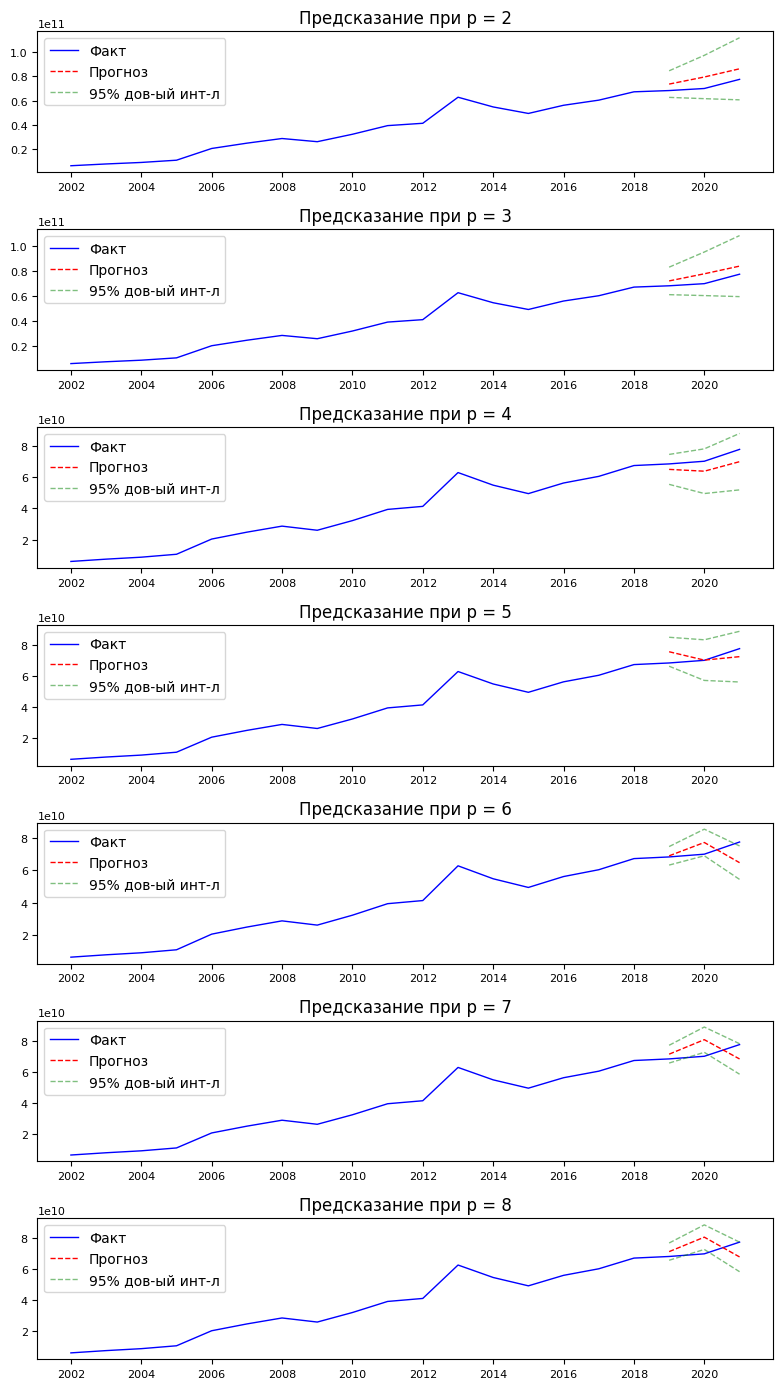

In [90]:
#Зададим список значений p для которых будем делать прогноз и рисовать график. 
p_list = [2,3,4,5,6,7,8]
fig, axes = plt.subplots(len(p_list), 1)

plt.rcParams["figure.figsize"] = 8, 14

for i,p in enumerate(p_list):
    #Обучим модель для каждого p из списка
    arima_model = ARIMA(train_df, order=(p, 3, 1))
    arima_model_fit = arima_model.fit()
    #Создадим таблицу итоговых данных для визуализации результатов по текущей модели
    pred_df = pd.DataFrame(index=data.index)
    pred_df["model_preds"] = arima_model_fit.predict(start=test_df.index[0], end=test_df.index[-1])
    pred_df["gpd"] = data["gpd"]
    forecast = arima_model_fit.get_forecast(len(test_df.index))
    forecast_df = forecast.conf_int(alpha=0.05)  # Confidence level of 95%
    pred_df.at[test_df.index, "model_preds_lower"] = forecast_df["lower gpd"]
    pred_df.at[test_df.index, "model_preds_upper"] = forecast_df["upper gpd"]
    pred_df = pred_df.iloc[-20:,:]
    #Собственно нарисум резельтат модели при текущем p на i-ой оси
    label = 'Предсказание при p = '+str(p)
    ax = axes[i]
    
    ax.plot(pred_df["gpd"], color="blue", label="Факт")
    ax.plot(pred_df.loc[test_df.index]["model_preds"],color="red",linestyle="--",label="Прогноз")
    ax.plot(pred_df.loc[test_df.index]["model_preds_lower"],color="green",linestyle="--",label="95% дов-ый инт-л",alpha=0.5)
    ax.plot(pred_df.loc[test_df.index]["model_preds_upper"],color="green",linestyle="--",alpha=0.5)
    ax.set_title(label)
    ax.legend()

plt.tight_layout()
#display(pred_df.iloc[-30:,:])

6. * Сделайте выводы по полученным результатам.

- - -
    Выводы и наблюдения:
    - Честно говоря, по графикам я делаю вывод, что я ошибся в выборе оптимального p. По мне так верное p = 4. Т.к. оно отражает общий тренд линейно вверх, но при этом занижает интервал доверительный вниз, на возможнрые изломы/отскоки, какой например был в 2012-2015 годах
    - Я специально делаю задания последовательно, для чистоты исследования и не корректирую предыдущие выводы. И хочу отметить, что по коррелограмме частичной автокорреляции, я выбирал именно p=4. Оно мне показалось самым перспективным кандидатом т.к. заметно сильнее выходило из "0ой зоны", чем 6.
    - Я думаю, что тут есть большая зависимость от задачи, и в принципе модель стоит стараться пробовать разные пограничные значения. Причем еще желательно тестировать на разных кусках временного ряда прогноз (устраивать что-то типа кросс-валидации) и подбирать такие параметры, которые показали лучшие результаты прогноза на этой "кросс-валидации". Например нарезать последние 12 лет на периоды по три месяца и выбирать параметры, которые покажут лучший прогноз посделоваьтельно на последние 3 года, 3 года до этого и т.д.. Или как-то похожим образом
    - Не уверен, что это общая закономерность для большинства рядов, но при уменьшении модуля ковариации на коррелограмме интервал доверительный сужается, и повышается возможное влияние нелинейностей в данных. Например, мне кажется, что на форму прогноза при p=6-8 повлиял излом в данных в 2012-2015 годах и он "как-бы" стал влиятельнее, чем общий линейный тренд. Вот такая гипотеза.
